# Análisis de Tarifas de Prepago en Operador de Telecomunicaciones

## ¿Cuál es la mejor tarifa?

Como analista, mi objetivo es determinar cuál de las tarifas prepago de Megaline, Surf o Ultimate, genera más ingresos para la empresa. Esto permitirá al departamento comercial ajustar el presupuesto de publicidad de manera efectiva y optimizar los recursos disponibles.

Para lograr esto, llevaré a cabo un análisis preliminar basado en una muestra de 500 clientes de Megaline. Dispongo de datos que incluyen información sobre quiénes son los clientes, su ubicación geográfica, qué tarifa están utilizando, así como detalles sobre la cantidad de llamadas realizadas y mensajes de texto enviados en 2018.

Mi tarea consistirá en examinar el comportamiento de los clientes en relación con las tarifas prepago y determinar cuál de ellas genera más ingresos para Megaline.

## Detalles de las Tarifas

Es importante tener en cuenta que Megaline redondea los segundos a minutos y los megabytes a gigabytes para sus tarifas. En el caso de las llamadas, cada llamada individual se redondea: incluso si la llamada dura solo un segundo, se contará como un minuto completo. En cuanto al tráfico web, el total del tráfico consumido en un mes se redondea hacia arriba. Por ejemplo, si un cliente utiliza 1025 megabytes este mes, se le cobrarán 2 gigabytes.

**Surf:**

1) Pago mensual: 20 dólares. 

2) 500 minutos al mes, 50 SMS y 15 GB.

3) Si se exceden los limites del paquete:

- 1 minuto: 3 centavos
- 1 SMS: 3 centavos
- 1 GB de datos: 10 dólares

**Ultimate:**

1) Pago mensual: 70 dólares.

2) 3000 minutos al mes, 1000 SMS y 30 GB de datos.

3) Si se exceden los límites del paquete:
- 1 minuto: 1 centavo.
- 1 SMS: 1 centavo.
- 1 GB de datos: 7dólares.






<a id="diccionario"></a>
# Diccionario de datos

En este proyecto, trabajaré con cinco tablas diferentes.

La tabla `users` (datos sobre los usuarios):
 
- `user_id`: identificador único del usuario.
- `first_name`: nombre del usuario.
- `last_name`: apellido del usuario.
- `age`: edad del usuario (en años).
- `reg_date`: fecha de suscripción (dd, mm, aa).
- `churn_date`: la fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos).
- `city`: ciudad de residencia del usuario.
- `plan`: nombre de la tarifa.

La tabla `calls` (datos sobre las llamadas):
 
- `id`: identificador único de la llamada.
- `call_date`: fecha de la llamada.
- `duration`: duración de la llamada (en minutos).
- `user_id`: el identificador del usuario que realiza la llamada.

La tabla `messages` (datos sobre los SMS):
 
- `id`: identificador único del SMS.
- `message_date`: fecha del SMS.
- `user_id`: el identificador del usuario que manda el SMS.

La tabla `internet` (datos sobre las sesiones web):
 
- `id`: identificador único de la sesión.
- `mb_used`: el volumen de datos gastados durante la sesión (en megabytes).
- `session_date`: fecha de la sesión web.
- `user_id`: identificador del usuario.

La tabla `plans` (datos sobre las tarifas):
 
- `plan_name`: nombre de la tarifa.
- `usd_monthly_fee`: pago mensual en dólares estadounidenses.
- `minutes_included`: minutos incluidos al mes.
- `messages_included`: SMS incluidos al mes.
- `mb_per_month_included`: datos incluidos al mes (en megabytes).
- `usd_per_minute`: precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos, el operador cobrará el minuto 101).
- `usd_per_message`: precio por SMS tras exceder los límites del paquete.
- `usd_per_gb`: precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes).


## Inicialización

In [1]:
# Cargar todas las librerías

import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats as st

import numpy as np

import math


## Cargar datos

In [2]:
# Cargar los archivos de datos en diferentes DataFrames

calls = pd.read_csv("megaline_calls.csv")

internet = pd.read_csv("megaline_internet.csv")

messages = pd.read_csv("megaline_messages.csv")

plans = pd.read_csv("megaline_plans.csv")

users = pd.read_csv("megaline_users.csv")


## Preparar los datos

En esta etapa, nuestro objetivo es preparar los datos para análisis posterior. Es crucial asegurarnos de que los datos estén en el formato adecuado y libres de errores, lo que nos permitirá realizar análisis precisos y confiables.

Para comenzar, convertiremos los datos en los tipos necesarios para facilitar su manipulación y análisis. A continuación, identificaremos y corregiremos cualquier error presente en los datos. Es importante abordar estos errores de manera adecuada y documentar nuestras acciones para mantener la transparencia y la trazabilidad en nuestro proceso de preparación de datos.

Este proceso de limpieza y preparación es fundamental para garantizar la calidad y confiabilidad de nuestros análisis posteriores.

## Tarifas

In [3]:
# Imprimir la información general/resumida sobre el DataFrame de las tarifas

plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprimir una muestra de los datos para las tarifas

plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Los datos parecen estar adecuadamente estructurados y completos en cuanto al precio de datos. No se observan problemas significativos, como tipos de datos inadecuados o datos faltantes. La información general y la muestra de datos impresa indican que todo está en orden con respecto a esta variable. Sin embargo, es importante tener en cuenta que se debe realizar una transformación de megabytes a gigabytes para asegurar la coherencia en el análisis de los datos. Este paso garantizará una interpretación correcta de las cantidades de datos utilizadas por los clientes y evitará posibles confusiones en el análisis posterior. Por lo tanto, además de verificar la integridad de los datos, también debemos considerar esta transformación como parte del proceso de preparación de datos. Una vez realizada esta conversión, los datos estarán listos para su análisis.

## Usuarios/as

In [5]:
# Imprimir la información general/resumida sobre el DataFrame de usuarios

users.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Imprimir una muestra de datos para usuarios

users.sample(5,random_state=26)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
246,1246,Stevie,Moran,69,"Tampa-St. Petersburg-Clearwater, FL MSA",2018-01-09,ultimate,2018-07-31
482,1482,Armand,Glenn,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaN
351,1351,Kyle,Grimes,47,"San Antonio-New Braunfels, TX MSA",2018-09-05,ultimate,NaN
129,1129,Marin,Bolton,70,"Baton Rouge, LA MSA",2018-11-10,surf,2018-12-27
176,1176,Terrance,Shaffer,75,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-10-03,surf,NaN


Al observar la información general y la muestra de datos impresa para el precio de datos anterior, se percibe una estructura clara en cada columna. Los únicos valores NaN se encuentran en la columna churn_date, lo cual es comprensible ya que estos registros corresponden a usuarios que aún no han cancelado el servicio. Para abordar este tema, simplemente ajustaremos el formato de las columnas reg_date y churn_date a datetime, lo que nos permitirá trabajar de manera consistente con fechas y tiempos.

### Corregir los datos

In [7]:
#Convertir las fechas a formato datetime
users["reg_date"] = pd.to_datetime(users["reg_date"], format='%Y-%m-%d')

users["churn_date"]=pd.to_datetime(users["churn_date"], format='%Y-%m-%d')

## Llamadas

In [8]:
# Imprimir la información general/resumida sobre el DataFrame de las llamadas

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
# Imprimir una muestra de datos para las llamadas

calls.sample(5,random_state=25)


,id,user_id,call_date,duration
59445,1214_514,1214,2018-04-12,1.87
34514,1130_34,1130,2018-11-12,0.00
54329,1196_212,1196,2018-10-31,9.29
132025,1475_172,1475,2018-09-10,0.00
16217,1064_75,1064,2018-10-27,2.79


En este caso, se requirió ajustar la columna call_date al formato datetime, lo cual se completó satisfactoriamente. Además, se redondeó hacia arriba la duración de las llamadas. Dado que Megaline redondea los segundos a minutos, cada llamada individual se redondea. Incluso si la llamada duró solo un segundo, se contará como un minuto.

### Corregir los datos

In [10]:
# Redondear hacia arriba los datos en la columna 'llamadas'
calls['duration'] = np.ceil(calls['duration'])

#Convertir las fechas a formato datetime
calls["call_date"] = pd.to_datetime(calls["call_date"], format='%Y-%m-%d')

## Mensajes

In [11]:
# Imprimir la información general/resumida sobre el DataFrame de los mensajes

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [12]:
# Imprimir una muestra de datos para los mensajes

messages.sample(5,random_state=26)

,id,user_id,message_date
40692,1261_351,1261,2018-04-20
68583,1444_66,1444,2018-09-23
24026,1144_529,1144,2018-11-19
55569,1349_270,1349,2018-12-06
11054,1077_325,1077,2018-08-28


En este caso, todo está en orden. Solamente se modificará la columna message_date para que esté en formato datetime

### Corregir los datos

In [13]:
#Covertir message_date a datetime
messages["message_date"] = pd.to_datetime(messages["message_date"], format='%Y-%m-%d')

## Internet

In [14]:
# Imprimir la información general/resumida sobre el DataFrame de internet

internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [15]:
# Imprimir una muestra de datos para el tráfico de internet

internet.sample(5,random_state=25)

,id,user_id,session_date,mb_used
4706,1028_265,1028,2018-09-19,205.11
39181,1176_2,1176,2018-12-10,165.55
74526,1351_12,1351,2018-12-20,132.41
54938,1249_131,1249,2018-08-22,504.56
7667,1041_507,1041,2018-10-05,0.00


En este caso, se ajustará la columna session_date para que esté en formato datetime. Es importante tener en cuenta que, además de esta transformación, cuando agrupemos los datos para el análisis posterior, será necesario redondear hacia arriba los valores resultantes de la transformación de megabytes a gigabytes. En este ejercicio, debemos realizar el redondeo superior, ya que el costo adicional se cobra en cuanto se superan los límites establecidos. Por lo tanto, después de convertir los datos de megabytes a gigabytes, procederemos a realizar el redondeo para garantizar la precisión y coherencia en nuestro análisis.

### Corregir los datos

In [16]:
#Convertir session_date a datetime
internet["session_date"] = pd.to_datetime(internet["session_date"], format='%Y-%m-%d')

## Estudiar las condiciones de las tarifas

In [17]:
# Imprimir las condiciones de la tarifa
plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

Ahora que los datos están limpios, procederemos a agregarlos por usuario y por periodo para garantizar que solo haya un registro por usuario y por periodo. Una vez agrupados los datos por usuario y por mes, añadiremos una columna con el número de llamadas `num_calls`, una columna con la suma de la duración de las llamadas `total_calls_duration`, una columna con el número de mensajes `num_messages` y una columna con el uso de internet por usuario en gigabytes `round_gb`. Finalmente, añadiremos una columna con la tarifa de cada usuario `plan` Ultimate o Surf. Este paso es crucial para simplificar el análisis posterior y asegurar la coherencia de los datos en la tabla resultante.

In [18]:
# Calcular el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
# Crear una nueva columna 'mes' que contenga el mes correspondiente para cada fecha
calls['month'] = calls['call_date'].dt.month

#Crear un Dataframe con las llamadas de cada usuario por mes
monthly_service_use = calls.groupby(['user_id', 'month']).size().reset_index(name='num_calls')

#Llamar al DataFrame
monthly_service_use

,user_id,month,num_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [19]:
# Calcular la cantidad de minutos usados por cada usuario al mes. Guardar el resultado.

total_calls_duration = calls.groupby(['user_id', 'month'])["duration"].sum().reset_index(name='total_calls_duration')

# Fusionar los DataFrames monthly_service_use y total_calls_duration
monthly_service_use = pd.merge(monthly_service_use, total_calls_duration, on=['user_id', 'month'], how='left')

#Llamar al DataFrame
monthly_service_use

,user_id,month,num_calls,total_calls_duration
0,1000,12,16,124.0
1,1001,8,27,182.0
2,1001,9,49,315.0
3,1001,10,65,393.0
4,1001,11,64,426.0
...,...,...,...,...
2253,1498,12,39,339.0
2254,1499,9,41,346.0
2255,1499,10,53,385.0
2256,1499,11,45,308.0


In [20]:
# Calcular el número de mensajes enviados por cada usuario al mes. Guardar el resultado.

messages["month"] = messages['message_date'].dt.month

monthly_messages = messages.groupby(['user_id', 'month']).size().reset_index(name='num_messages')

# Fusionar los DataFrames monthly_service_use y monthly_messages
monthly_service_use = pd.merge(monthly_service_use, monthly_messages, on=['user_id', 'month'], how='left')

#Reemplazar valores NaN por 0

monthly_service_use['num_messages'].fillna(0, inplace=True) 

monthly_service_use




,user_id,month,num_calls,total_calls_duration,num_messages
0,1000,12,16,124.0,11.0
1,1001,8,27,182.0,30.0
2,1001,9,49,315.0,44.0
3,1001,10,65,393.0,53.0
4,1001,11,64,426.0,36.0
...,...,...,...,...,...
2253,1498,12,39,339.0,0.0
2254,1499,9,41,346.0,0.0
2255,1499,10,53,385.0,0.0
2256,1499,11,45,308.0,0.0


In [21]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

internet["month"] = internet['session_date'].dt.month

monthly_mb_used = internet.groupby(['user_id', 'month'])["mb_used"].sum().reset_index(name='total_mb_used')

#Transformar a GB y redondear ya que las tarifas se calculan en base a GB
monthly_mb_used['round_gb'] = np.ceil(monthly_mb_used['total_mb_used'] / 1024)

# Fusionar los DataFrames monthly_service_use y monthly_mb_used
monthly_service_use = pd.merge(monthly_service_use, monthly_mb_used[['user_id', 'month', 'round_gb']], on=['user_id', 'month'], how='left')

monthly_service_use['round_gb'].fillna(0, inplace=True) 

monthly_service_use

,user_id,month,num_calls,total_calls_duration,num_messages,round_gb
0,1000,12,16,124.0,11.0,2.0
1,1001,8,27,182.0,30.0,7.0
2,1001,9,49,315.0,44.0,14.0
3,1001,10,65,393.0,53.0,22.0
4,1001,11,64,426.0,36.0,19.0
...,...,...,...,...,...,...
2253,1498,12,39,339.0,0.0,23.0
2254,1499,9,41,346.0,0.0,13.0
2255,1499,10,53,385.0,0.0,20.0
2256,1499,11,45,308.0,0.0,17.0


In [22]:
# Mostrar la tabla donde cada fila representa el consumo de cada usuario  de llamadas, minutos, mensajes e Internet con base en user_id y month
monthly_service_use


,user_id,month,num_calls,total_calls_duration,num_messages,round_gb
0,1000,12,16,124.0,11.0,2.0
1,1001,8,27,182.0,30.0,7.0
2,1001,9,49,315.0,44.0,14.0
3,1001,10,65,393.0,53.0,22.0
4,1001,11,64,426.0,36.0,19.0
...,...,...,...,...,...,...
2253,1498,12,39,339.0,0.0,23.0
2254,1499,9,41,346.0,0.0,13.0
2255,1499,10,53,385.0,0.0,20.0
2256,1499,11,45,308.0,0.0,17.0


In [23]:
# Añadir la información de la tarifa

monthly_service_use = monthly_service_use.merge(users[['user_id', 'plan']], on='user_id', how='outer')


monthly_service_use


,user_id,month,num_calls,total_calls_duration,num_messages,round_gb,plan
0,1000,12.0,16.0,124.0,11.0,2.0,ultimate
1,1001,8.0,27.0,182.0,30.0,7.0,surf
2,1001,9.0,49.0,315.0,44.0,14.0,surf
3,1001,10.0,65.0,393.0,53.0,22.0,surf
4,1001,11.0,64.0,426.0,36.0,19.0,surf
...,...,...,...,...,...,...,...
2272,1319,NaN,NaN,NaN,NaN,NaN,surf
2273,1349,NaN,NaN,NaN,NaN,NaN,surf
2274,1378,NaN,NaN,NaN,NaN,NaN,surf
2275,1463,NaN,NaN,NaN,NaN,NaN,ultimate


Ahora nos adentraremos en el cálculo de los ingresos mensuales por usuario. Este proceso nos permitirá posteriormente agrupar a los usuarios según su tarifa y realizar comparaciones relevantes para el análisis. Crearemos una nueva columna llamada `income` donde almacenaremos esta información.

In [24]:
# Calcula el ingreso mensual para cada usuario

def calcular_costo_extra(user):
    if user["plan"] == "surf":
        plan = 20
        call_price = 0.03
        sms_price = 0.03
        gb_price = 10
        
        # Resta el límite del paquete gratuito del número total de llamadas
        calls_total = user["num_calls"] - 500
        # Resta el límite del paquete gratuito del número total de mensajes de texto
        sms_total = user["num_messages"] - 50
        # Resta el límite del paquete gratuito del número total de datos
        gb_total = user["round_gb"] - 15
        
        # Calcula el costo extra por llamadas
        extra_calls = max(0, calls_total) * call_price
        # Calcula el costo extra por mensajes de texto
        extra_sms = max(0, sms_total) * sms_price
        # Calcula el costo extra por GB de datos
        extra_gb = max(0, gb_total) * gb_price
        
        # Calcula el costo total sumando los costos extra y el costo del plan
        result = extra_calls + extra_sms + extra_gb + plan
        return result
    elif user["plan"] == "ultimate":
        plan = 70
        call_price = 0.01
        sms_price = 0.01
        gb_price = 7
        
        # Resta el límite del paquete gratuito del número total de llamadas
        calls_total = user["num_calls"] - 3000
        # Resta el límite del paquete gratuito del número total de mensajes de texto
        sms_total = user["num_messages"] - 1000
        # Resta el límite del paquete gratuito del número total de datos
        gb_total = user["round_gb"] - 30
        
        # Calcula el costo extra por llamadas
        extra_calls = max(0, calls_total) * call_price
        # Calcula el costo extra por mensajes de texto
        extra_sms = max(0, sms_total) * sms_price
        # Calcula el costo extra por GB de datos
        extra_gb = max(0, gb_total) * gb_price
        
        # Calcula el costo total sumando los costos extra y el costo del plan
        result = extra_calls + extra_sms + extra_gb + plan
        return result
        
        
monthly_service_use["income"] = monthly_service_use.apply(calcular_costo_extra, axis=1)


monthly_service_use.sample(20)

,user_id,month,num_calls,total_calls_duration,num_messages,round_gb,plan,income
1007,1216,9.0,15.0,100.0,0.0,5.0,surf,20.00
1876,1408,3.0,73.0,526.0,36.0,17.0,surf,40.00
1068,1232,8.0,79.0,635.0,0.0,16.0,surf,30.00
1885,1408,12.0,66.0,486.0,32.0,15.0,surf,20.00
1152,1251,8.0,83.0,614.0,20.0,34.0,surf,210.00
2014,1440,8.0,89.0,698.0,40.0,22.0,surf,90.00
780,1167,5.0,18.0,176.0,16.0,4.0,surf,20.00
1845,1403,7.0,17.0,134.0,0.0,18.0,ultimate,70.00
463,1099,10.0,72.0,515.0,24.0,20.0,surf,70.00
1104,1241,9.0,72.0,485.0,20.0,9.0,surf,20.00


## Estudia el comportamiento de usuario

Ahora nos enfocaremos en calcular algunas estadísticas descriptivas para el consumo de llamadas, mensajes e internet. También crearemos gráficos que sean útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa. Además, consideraremos otros aspectos relevantes para el análisis, como la distribución del consumo por período y la variación mensual en el uso de servicios.

### Llamadas

In [25]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

average_monthly_calls = monthly_service_use.groupby(["plan","month"])["total_calls_duration"].mean().reset_index()

average_monthly_calls


,plan,month,total_calls_duration
0,surf,1.0,203.000000
1,surf,2.0,297.000000
2,surf,3.0,330.000000
3,surf,4.0,351.540000
4,surf,5.0,410.240000
5,surf,6.0,435.791667
6,surf,7.0,453.733333
7,surf,8.0,417.849057
8,surf,9.0,420.732984
9,surf,10.0,438.991379


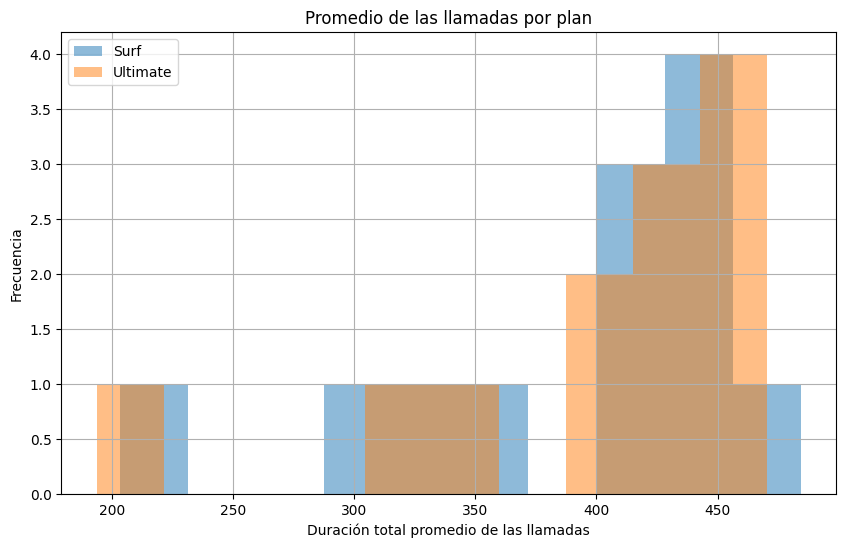

In [26]:
# Comparar el número de minutos mensuales que necesitan los usuarios de cada plan. Trazar un Histograma
# Filtrar los datos para el plan "surf" y "ultimate"

surf_data_calls = average_monthly_calls[average_monthly_calls["plan"] == "surf"]
ultimate_data_calls = average_monthly_calls[average_monthly_calls["plan"] == "ultimate"]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos para el plan "surf"
plt.hist(surf_data_calls["total_calls_duration"], bins=10, alpha=0.5, label='Surf')

# Graficar los datos para el plan "ultimate"
plt.hist(ultimate_data_calls["total_calls_duration"], bins=10, alpha=0.5, label='Ultimate')

# Añadir etiquetas y título
plt.xlabel("Duración total promedio de las llamadas")
plt.ylabel("Frecuencia")
plt.title("Promedio de las llamadas por plan")
plt.legend()
plt.grid(True)



    

Ahora nos enfocaremos en calcular la media y la variabilidad de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de manera diferente al realizar sus llamadas.

In [27]:
# Calcular la media y la varianza de la duración mensual de llamadas.
#Calcular la media de duración de llamadas del plan ultimate
mean_calls_ultimate= average_monthly_calls[average_monthly_calls["plan"] == "ultimate"]["total_calls_duration"].mean()

#Calcular la media de duración de llamadas del plan surf
mean_calls_surf= average_monthly_calls[average_monthly_calls["plan"] == "surf"]["total_calls_duration"].mean()

#Calcular la varianza de duración de llamadas del plan ultimate
var_calls_ultimate =average_monthly_calls[average_monthly_calls["plan"] == "ultimate"]["total_calls_duration"].var()

#Calcular la varianza de duración de llamadas del plan surf
var_calls_surf= average_monthly_calls[average_monthly_calls["plan"] == "surf"]["total_calls_duration"].var()

print(f'La media del plan ultimate es de: {mean_calls_ultimate} y la media del plan surf es de: {mean_calls_surf}')

print(f'La varianza del plan ultimate es de: {var_calls_ultimate} y la varianza del plan surf es de: {var_calls_surf}')

La media del plan ultimate es de: 396.13856827549125 y la media del plan surf es de: 389.6562177301583
La varianza del plan ultimate es de: 6638.451229390735 y la varianza del plan surf es de: 6374.619145867013


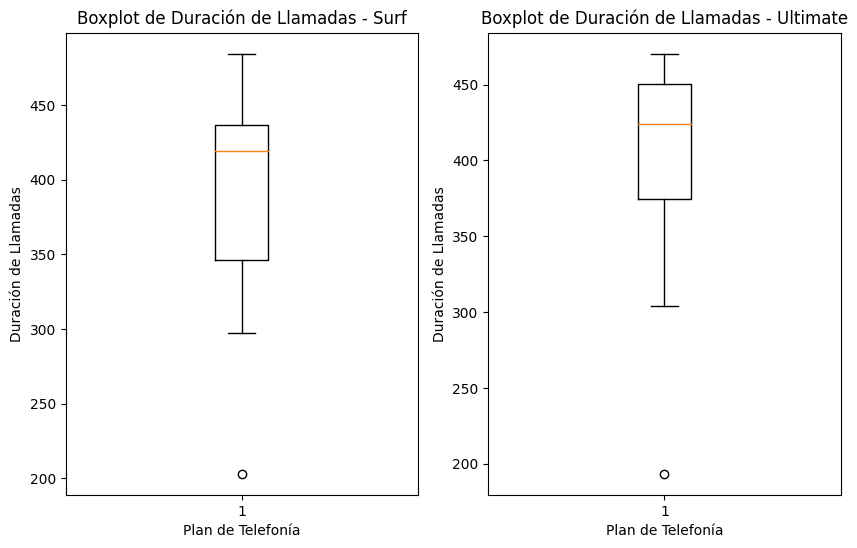

In [28]:
# Trazar un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

# Crear una figura y ejes para los gráficos de caja
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Graficar el boxplot para el plan "Surf"
axes[0].boxplot(surf_data_calls['total_calls_duration'])
axes[0].set_title('Boxplot de Duración de Llamadas - Surf')

# Graficar el boxplot para el plan "Ultimate"
axes[1].boxplot(ultimate_data_calls['total_calls_duration'])
axes[1].set_title('Boxplot de Duración de Llamadas - Ultimate')

# Configurar etiquetas
for ax in axes:
    ax.set_xlabel('Plan de Telefonía')
    ax.set_ylabel('Duración de Llamadas')

En base al análisis del histograma, las estadísticas de las medias y varianzas, así como los gráficos de cajas, se observa que la media del plan Ultimate es ligeramente mayor que la del plan Surf, mientras que la varianza del plan Ultimate es ligeramente más alta en comparación con el plan Surf. Sin embargo, ambas distribuciones de datos, representadas tanto en los histogramas como en los gráficos de cajas, muestran una tendencia similar, con una concentración alrededor de las medias calculadas. Esto sugiere que el comportamiento de los usuarios en cuanto a la duración de las llamadas es bastante similar entre ambos planes, lo que refuerza la idea de que no hay una diferencia significativa en el consumo mensual de llamadas entre los dos planes.

### Mensajes

In [29]:
# Comparar el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

average_monthly_sms = monthly_service_use.groupby(["plan","month"])["num_messages"].mean().reset_index()

average_monthly_sms


,plan,month,num_messages
0,surf,1.0,10.500000
1,surf,2.0,12.000000
2,surf,3.0,15.260870
3,surf,4.0,17.400000
4,surf,5.0,24.386667
5,surf,6.0,25.281250
6,surf,7.0,27.025000
7,surf,8.0,28.855346
8,surf,9.0,30.376963
9,surf,10.0,33.267241


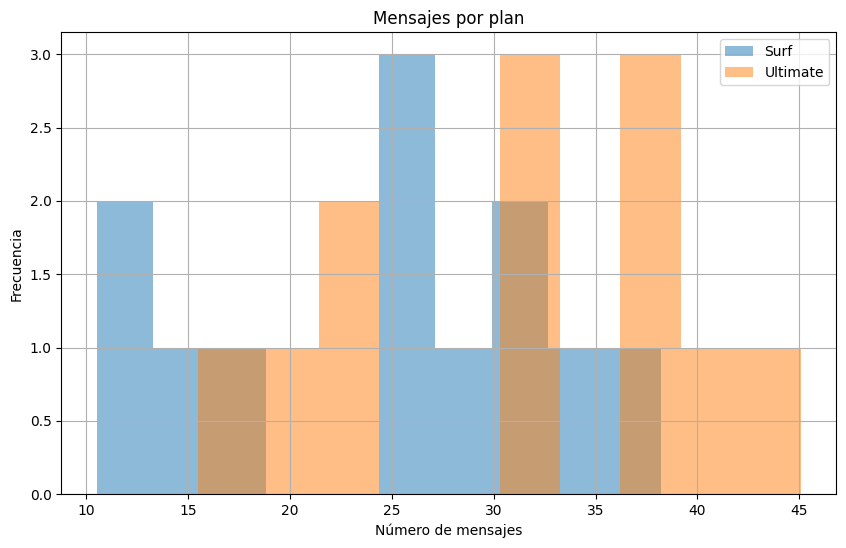

In [30]:
# Comparar el número de mensajes mensuales que necesitan los usuarios de cada plan. Trazar un Histograma
# Filtrar los datos para el plan "surf" y "ultimate"

surf_data_sms = average_monthly_sms[average_monthly_sms["plan"] == "surf"]
ultimate_data_sms = average_monthly_sms[average_monthly_sms["plan"] == "ultimate"]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos para el plan "surf"
plt.hist(surf_data_sms["num_messages"], bins=10, alpha=0.5, label='Surf')

# Graficar los datos para el plan "ultimate"
plt.hist(ultimate_data_sms["num_messages"], bins=10, alpha=0.5, label='Ultimate')

# Añadir etiquetas y título
plt.xlabel("Número de mensajes")
plt.ylabel("Frecuencia")
plt.title("Mensajes por plan")
plt.legend()
plt.grid(True)


In [31]:
# Calcular la media y la varianza de mensajes mensuales.

#Calcular la media de duración de mensajes del plan ultimate
mean_sms_ultimate= average_monthly_sms[average_monthly_sms["plan"] == "ultimate"]["num_messages"].mean()

#Calcular la media de duración de llamadas del plan surf
mean_sms_surf= average_monthly_sms[average_monthly_sms["plan"] == "surf"]["num_messages"].mean()

#Calcular la varianza de número de mensajes del plan ultimate
var_sms_ultimate =average_monthly_sms[average_monthly_sms["plan"] == "ultimate"]["num_messages"].var()

#Calcular la varianza de duración de llamadas del plan surf
var_sms_surf= average_monthly_sms[average_monthly_sms["plan"] == "surf"]["num_messages"].var()

print(f'La media de mensajes del plan ultimate es de: {mean_sms_ultimate} y la media del plan surf es de: {mean_sms_surf}')

print(f'La varianza del plan ultimate es de: {var_sms_ultimate} y la varianza del plan surf es de: {var_sms_surf}')



La media de mensajes del plan ultimate es de: 31.356034273018 y la media del plan surf es de: 24.55675658242926
La varianza del plan ultimate es de: 85.2182244500177 y la varianza del plan surf es de: 79.21591746120484


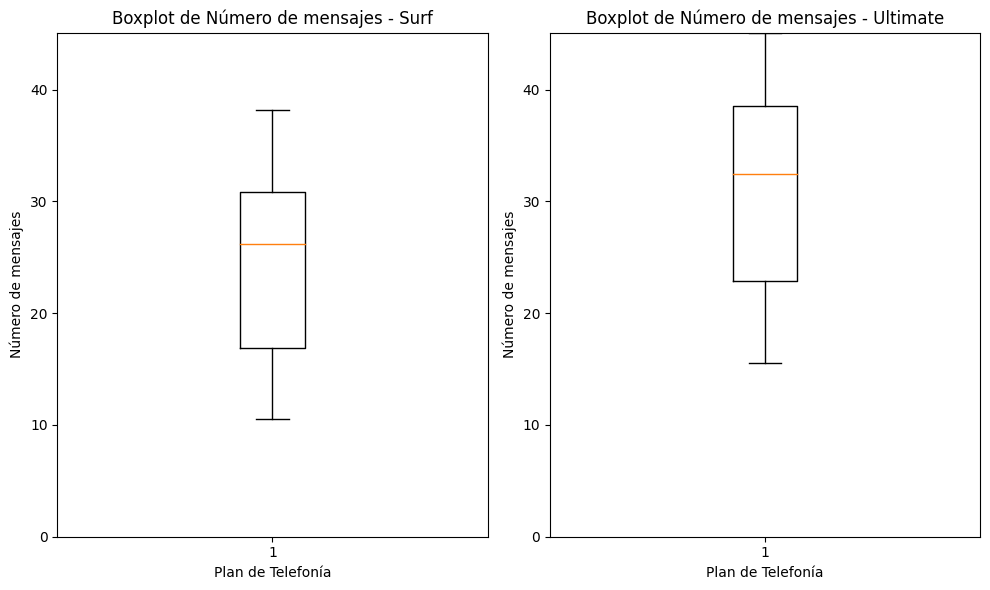

In [32]:
# Trazar un diagrama de caja para visualizar la distribución del número mensal de mensajes

# Calcular el rango máximo de mensajes para establecer el mismo rango en ambos gráficos
max_messages = max(surf_data_sms["num_messages"].max(), ultimate_data_sms["num_messages"].max())

# Crear una figura y ejes para los gráficos de caja
plt.figure(figsize=(10, 6))

# Graficar el boxplot para el plan "Surf"
plt.subplot(1, 2, 1)
plt.boxplot(surf_data_sms["num_messages"])
plt.title('Boxplot de Número de mensajes - Surf')
plt.xlabel('Plan de Telefonía')
plt.ylabel('Número de mensajes')
plt.ylim(0, max_messages)  # Establecer el mismo rango en el eje y para ambos gráficos

# Graficar el boxplot para el plan "Ultimate"
plt.subplot(1, 2, 2)
plt.boxplot(ultimate_data_sms["num_messages"])
plt.title('Boxplot de Número de mensajes - Ultimate')
plt.xlabel('Plan de Telefonía')
plt.ylabel('Número de mensajes')
plt.ylim(0, max_messages)  # Establecer el mismo rango en el eje y para ambos gráficos

plt.tight_layout()


Los datos analizados revelan diferencias significativas en el comportamiento de mensajería entre los usuarios de los planes Surf y Ultimate. La media del número de mensajes para el plan Ultimate es mayor que para el plan Surf, indicando un mayor uso de mensajes por parte de los usuarios de Ultimate. Esta disparidad se ve reflejada en los histogramas, donde el plan Surf muestra un pico alrededor de los 25 mensajes, mientras que el plan Ultimate exhibe dos picos, uno alrededor de los 30 mensajes y otro alrededor de los 35 mensajes. Los diagramas de cajas corroboran estas diferencias, con una mediana más alta y un rango intercuartílico más amplio para el plan Ultimate en comparación con el plan Surf. Además, las varianzas muestran una mayor variabilidad en el número de mensajes para el plan Ultimate. En resumen, los usuarios de Ultimate tienden a enviar más mensajes en promedio y muestran una mayor diversidad en sus patrones de mensajería en comparación con los usuarios de Surf.

### Internet

In [33]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

average_monthly_gb = monthly_service_use.groupby(["plan","month"])["round_gb"].mean().reset_index()

average_monthly_gb

,plan,month,round_gb
0,surf,1.0,5.000000
1,surf,2.0,12.222222
2,surf,3.0,13.565217
3,surf,4.0,12.220000
4,surf,5.0,14.373333
5,surf,6.0,15.489583
6,surf,7.0,16.875000
7,surf,8.0,16.955975
8,surf,9.0,16.544503
9,surf,10.0,17.344828


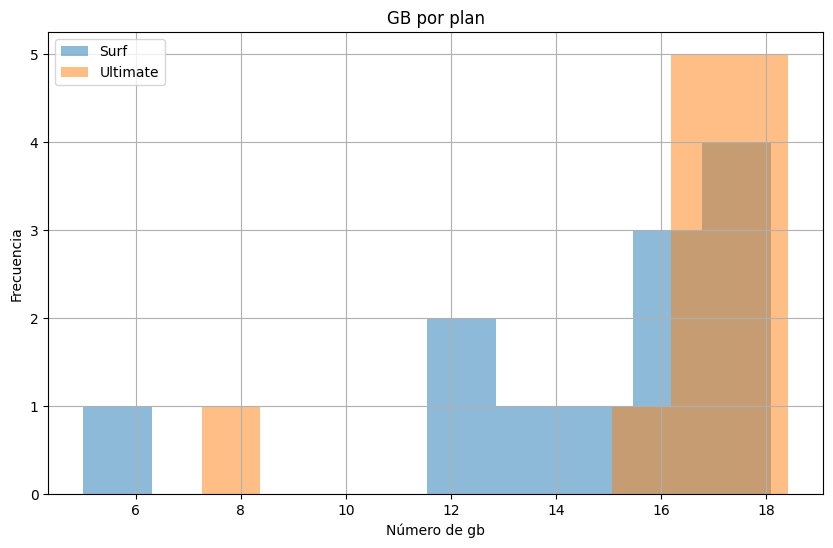

In [34]:
# Compara el número de gb mensuales que necesitan los usuarios de cada plan. Trazar un Histograma
# Filtrar los datos para el plan "surf" y "ultimate"

surf_data_gb = average_monthly_gb[average_monthly_sms["plan"] == "surf"]
ultimate_data_gb = average_monthly_gb[average_monthly_sms["plan"] == "ultimate"]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos para el plan "surf"
plt.hist(surf_data_gb["round_gb"], bins=10, alpha=0.5, label='Surf')

# Graficar los datos para el plan "ultimate"
plt.hist(ultimate_data_gb["round_gb"], bins=10, alpha=0.5, label='Ultimate')

# Añadir etiquetas y título
plt.xlabel("Número de gb")
plt.ylabel("Frecuencia")
plt.title("GB por plan")
plt.legend()
plt.grid(True)

In [35]:
# Calcular la media y la varianza de GB mensuales.

#Calcular la media de  GB del plan ultimate
mean_gb_ultimate= average_monthly_gb[average_monthly_gb["plan"] == "ultimate"]["round_gb"].mean()

#Calcular la media  de GB del plan surf
mean_gb_surf= average_monthly_gb[average_monthly_gb["plan"] == "surf"]["round_gb"].mean()

#Calcular la varianza de GB del plan ultimate
var_gb_ultimate =average_monthly_gb[average_monthly_gb["plan"] == "ultimate"]["round_gb"].var()

#Calcular la varianza de GB del plan surf
var_gb_surf= average_monthly_gb[average_monthly_gb["plan"] == "surf"]["round_gb"].var()

print(f'La media de GB del plan ultimate es de: {mean_sms_ultimate} y la media del plan surf es de: {mean_gb_surf}')

print(f'La varianza de GB del plan ultimate es de: {var_sms_ultimate} y la varianza del plan surf es de: {var_gb_surf}')


La media de GB del plan ultimate es de: 31.356034273018 y la media del plan surf es de: 14.58888169962811
La varianza de GB del plan ultimate es de: 85.2182244500177 y la varianza del plan surf es de: 12.982942071070948


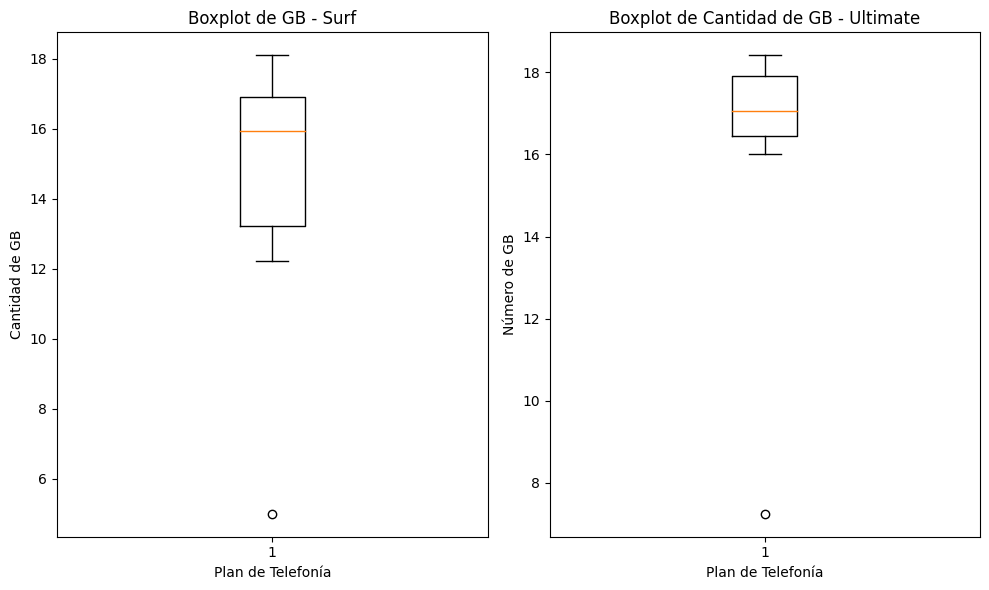

In [36]:
# Traza un diagrama de caja para visualizar la distribución del número mensal de GB

# Crear una figura y ejes para los gráficos de caja
plt.figure(figsize=(10, 6))

# Graficar el boxplot para el plan "Surf"
plt.subplot(1, 2, 1)
plt.boxplot(surf_data_gb["round_gb"])
plt.title('Boxplot de GB - Surf')
plt.xlabel('Plan de Telefonía')
plt.ylabel('Cantidad de GB')

# Graficar el boxplot para el plan "Ultimate"
plt.subplot(1, 2, 2)
plt.boxplot(ultimate_data_gb["round_gb"])
plt.title('Boxplot de Cantidad de GB - Ultimate')
plt.xlabel('Plan de Telefonía')
plt.ylabel('Número de GB')

plt.tight_layout()

Los datos analizados revelan diferencias significativas en el comportamiento de uso de gigabytes de internet entre los usuarios de los planes Surf y Ultimate. La media del número de gigabytes para el plan Ultimate es notablemente mayor que para el plan Surf, indicando un uso más intensivo de internet por parte de los usuarios de Ultimate. Esta disparidad se refleja claramente en los histogramas, donde el plan Ultimate muestra un pico más alto en el rango entre 16 y 18, mientras que el plan Surf presenta un pico más bajo en ese mismo intervalo. Los diagramas de cajas también confirman estas diferencias, mostrando una mayor concentración de datos alrededor de la mediana para el plan Ultimate, lo que se traduce en un rango intercuartílico aparentemente más estrecho. A pesar de la aparente discrepancia, las varianzas revelan una mayor variabilidad en los gigabytes de internet para el plan Ultimate en comparación con el plan Surf. En resumen, los usuarios de Ultimate tienden a utilizar más gigabytes en promedio y muestran una mayor diversidad en sus patrones de uso de internet en comparación con los usuarios de Surf.

## Ingreso

Ahora nos concentraremos en analizar estadísticamente los ingresos de los diferentes planes de servicio Este análisis detallado nos ayudará a comprender la distribución y variabilidad de los ingresos, lo que nos permitirá identificar patrones clave.

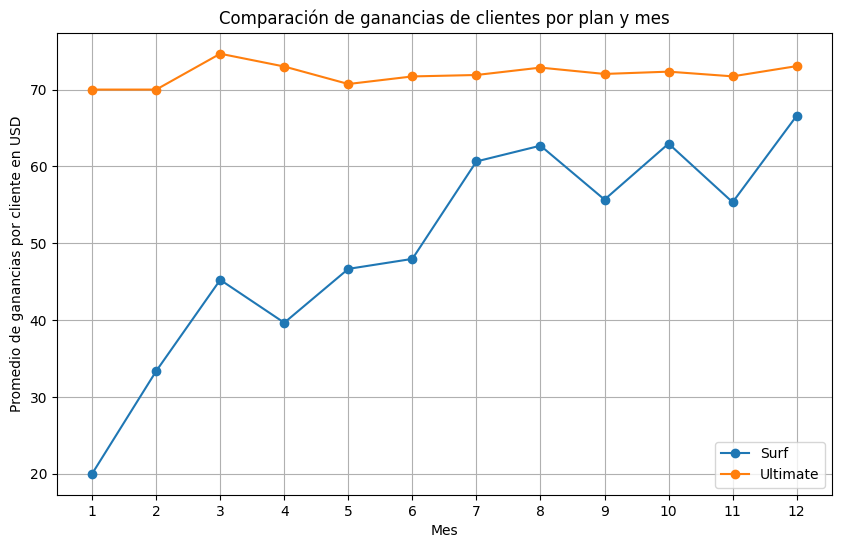

In [37]:
# Compara la duración promedio de ingresos por cada plan y por cada mes. 

average_monthly_income = monthly_service_use.groupby(["plan","month"])["income"].mean().reset_index()

average_monthly_income

# Filtrar los datos para el plan "surf" y "ultimate"

surf_income = average_monthly_income[average_monthly_income["plan"] == "surf"]
ultimate_income = average_monthly_income[average_monthly_income["plan"] == "ultimate"]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos para el plan "surf"
plt.plot(surf_income["month"], surf_income["income"], marker='o', label='Surf')

# Graficar los datos para el plan "ultimate"
plt.plot(ultimate_income["month"], ultimate_income["income"], marker='o', label='Ultimate')

# Añadir etiquetas y título
plt.grid(True)
plt.xlabel("Mes")
plt.ylabel("Promedio de ganancias por cliente en USD")
plt.title("Comparación de ganancias de clientes por plan y mes")
plt.xticks(range(1, 13))  # Asegurar que los meses estén etiquetados del 1 al 12
plt.legend()



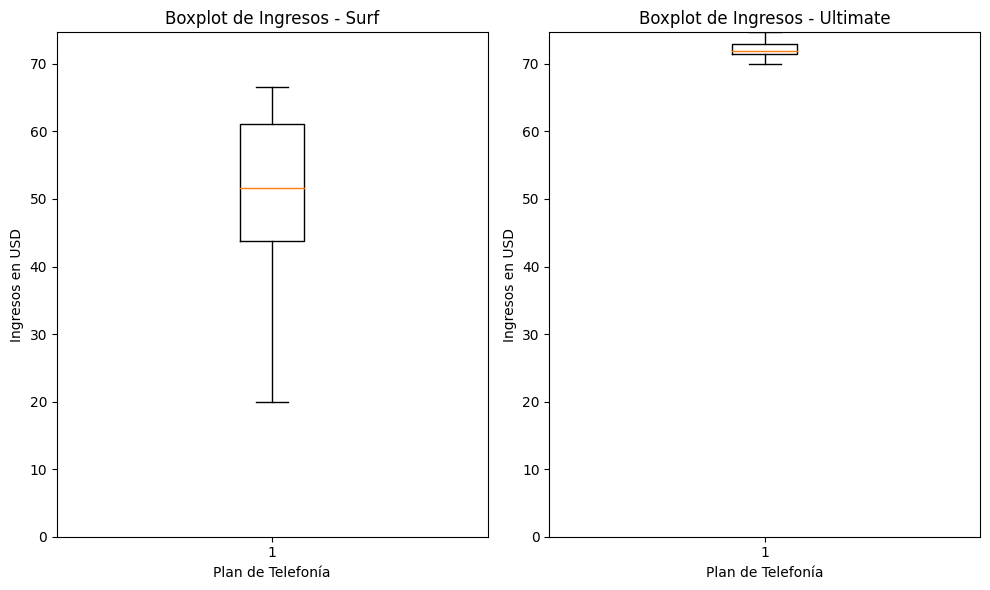

In [38]:
# Obtener los máximos valores de ingresos para ambos planes
max_income = max(surf_income["income"].max(), ultimate_income["income"].max())

# Crear una figura y ejes para los gráficos de caja
plt.figure(figsize=(10, 6))

# Graficar el boxplot para el plan "Surf"
plt.subplot(1, 2, 1)
plt.boxplot(surf_income["income"])
plt.title('Boxplot de Ingresos - Surf')
plt.xlabel('Plan de Telefonía')
plt.ylabel('Ingresos en USD')
plt.ylim(0, max_income)  # Establecer el límite del eje y para que sea el mismo en ambos gráficos

# Graficar el boxplot para el plan "Ultimate"
plt.subplot(1, 2, 2)
plt.boxplot(ultimate_income["income"])
plt.title('Boxplot de Ingresos - Ultimate')
plt.xlabel('Plan de Telefonía')
plt.ylabel('Ingresos en USD')
plt.ylim(0, max_income)  # Establecer el límite del eje y para que sea el mismo en ambos gráficos

plt.tight_layout()
plt.show()



In [39]:
# Obtener el resumen estadístico para surf_income 
surf_income.describe()


,month,income
count,12.000000,12.000000
mean,6.500000,49.732154
std,3.605551,13.815942
min,1.000000,20.000000
25%,3.750000,43.838811
50%,6.500000,51.649950
75%,9.250000,61.159702
max,12.000000,66.588521


In [40]:
# Obtener el resumen estadístico para ultimate_income 
ultimate_income.describe()

,month,income
count,12.000000,12.000000
mean,6.500000,72.000292
std,3.605551,1.344032
min,1.000000,70.000000
25%,3.750000,71.464368
50%,6.500000,71.966594
75%,9.250000,72.894366
max,12.000000,74.666667


En el análisis de los datos de ingresos por cliente y mes, se observa una consistencia notable en los ingresos del plan Ultimate, que se mantienen alrededor de 70 dólares a lo largo del año. Por el contrario, los ingresos del plan Surf muestran una tendencia ascendente, comenzando alrededor de 20 dólares al principio del año y aumentando gradualmente hasta alcanzar casi 70 dólares en diciembre. Estas cifras sugieren que, en promedio, los clientes del plan Ultimate generan ingresos más estables en comparación con los del plan Surf. Además, al examinar la desviación estándar, se observa que la variabilidad de los ingresos es mucho mayor en el plan Surf (13.82) en comparación con el plan Ultimate (1.34). Esto indica que los ingresos del plan Surf tienden a fluctuar más ampliamente en torno a su media, lo que refleja una mayor incertidumbre en los ingresos mensuales. Este patrón se confirma visualmente en el diagrama de cajas, donde el rango intercuartílico del plan Surf es más amplio, lo que sugiere una mayor dispersión de los ingresos en comparación con el plan Ultimate, donde la mayoría de los ingresos se concentran alrededor del valor medio.

## Prueba las hipótesis estadísticas

Ahora realizaremos una prueba para evaluar si existen diferencias significativas en los ingresos promedio entre los usuarios de los planes de llamada Ultimate y Surf.

Para ello, primero elaboraremos las hipótesis nula y alternativa. La hipótesis nula (H0) establece que no hay diferencia en los ingresos promedio entre los usuarios de los planes Ultimate y Surf, mientras que la hipótesis alternativa (H1) sugiere que sí hay una diferencia en los ingresos promedio entre estos usuarios.



Luego, utilizando la prueba t de Welch (st.ttest_ind) con un valor alfa de 0.05, evaluaremos los resultados obtenidos para determinar si podemos rechazar o no la hipótesis nula.

In [41]:
# Definir hipótesis nula y alternativa
H0_no_difference_income_plans = "No hay diferencia en los ingresos promedio entre los usuarios de los planes Ultimate y Surf."
H1_difference_income_plans = "Hay una diferencia en los ingresos promedio entre los usuarios de los planes Ultimate y Surf."

# Nivel de significancia estadística (alfa)
alpha = 0.05

# Realizar la prueba de hipótesis
results = st.ttest_ind(surf_income["income"], ultimate_income["income"], equal_var=False)

# Comprobar si rechazamos o no la hipótesis nula
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula que dice:", H0_no_difference_income_plans)
    print("Hay evidencia suficiente para sugerir que hay una diferencia significativa en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.")
else:
    print("No podemos rechazar la hipótesis nula:", H0_no_difference_income_plans)
    print("No hay suficiente evidencia para sugerir que hay una diferencia significativa en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.")


Rechazamos la hipótesis nula que dice: No hay diferencia en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.
Hay evidencia suficiente para sugerir que hay una diferencia significativa en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.


Ahora procederemos a realizar una prueba para evaluar si el ingreso promedio de los usuarios del área New York-Newark-Jersey City, NY-NJ-PA MSA es diferente al de los usuarios de otras regiones.

Para ello, primero elaboraremos las hipótesis nula y alternativa. La hipótesis nula (H0) establece que no hay diferencia en el ingreso promedio entre los usuarios del área New York-Newark-Jersey City, NY-NJ-PA MSA y los usuarios de otras regiones, mientras que la hipótesis alternativa (H1) sugiere que sí hay una diferencia en el ingreso promedio entre estos grupos de usuarios.



Luego, seleccionaremos la prueba estadística adecuada, en este caso, utilizaremos la prueba t de Welch (st.ttest_ind) de la biblioteca scipy.stats. Utilizaremos un valor alfa de 0.05 para determinar si podemos rechazar o no la hipótesis nula.

In [42]:
#Combinar monthly_service_use con la columna de ciudad de users
#how=inner para no considerar los clientes con plan cancelado
monthly_service_used = pd.merge(monthly_service_use, users[['user_id', 'city']], on='user_id', how='inner')

# Filtrar las filas donde la columna "New York-Newark-Jersey City, NY-NJ-PA MSA" 
ny_nj_data = monthly_service_used[monthly_service_used['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']

# Calcular el promedio de la columna "income" para New York-Newark-Jersey City, NY-NJ-PA MSA"
promedio_income_ny_nj = ny_nj_data['income'].mean()

# Filtrar las filas donde la columna "city" no es igual a "New York-Newark-Jersey City, NY-NJ-PA MSA"
other_locations_data = monthly_service_used[monthly_service_used['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']

#Calcular el promedio de la columna "income" para todas las ubicaciones excepto "New York-Newark-Jersey City, NY-NJ-PA MSA" 
promedio_income_otros = other_locations_data['income'].mean()

# Definir las hipótesis
H0 = "No hay diferencia en los ingresos promedio entre los usuarios del área NY-NJ y los demás usuarios"
H1 = "Hay una diferencia en los ingresos promedio entre los usuarios del área NY-NJ y los demás usuarios"

# Filtrar los datos para usuarios del área NY-NJ y los demás usuarios
ny_nj_data = monthly_service_used[monthly_service_used['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']
otros_data = monthly_service_used[monthly_service_used['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']

# Realizar la prueba de hipótesis
alpha = 0.05
results = st.ttest_ind(ny_nj_data["income"], otros_data["income"], equal_var=False)

# Comprobar si rechazamos o no la hipótesis nula
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula que dice:", H0)
else:
    print("No podemos rechazar la hipótesis nula:", H0)



Rechazamos la hipótesis nula que dice: No hay diferencia en los ingresos promedio entre los usuarios del área NY-NJ y los demás usuarios


## Conclusión general


**Comportamiento de llamadas:**

Las estadísticas de medias y varianzas, así como los histogramas y gráficos de cajas, revelan similitudes en la duración de llamadas entre los planes Surf y Ultimate. La media del plan Ultimate es ligeramente mayor que la del plan Surf, aunque la varianza del plan Ultimate es algo más alta.

**Comportamiento de mensajería:**

Se observan diferencias significativas en el comportamiento de mensajería entre los usuarios de los planes Surf y Ultimate. La media del número de mensajes es mayor en el plan Ultimate, lo que se refleja en histogramas y gráficos de cajas con picos más altos y mayor variabilidad en comparación con el plan Surf.

**Comportamiento de uso de internet:**

Se encuentran diferencias notables en el comportamiento de uso de gigabytes de internet entre los usuarios de los planes Surf y Ultimate. La media del número de gigabytes es más alta en el plan Ultimate, con una mayor concentración de datos en este plan según histogramas y gráficos de cajas.

**Ingresos por cliente y mes:**

Los ingresos del plan Ultimate muestran una consistencia alrededor de 70 dólares, mientras que los del plan Surf tienen una tendencia ascendente a lo largo del año. La variabilidad de los ingresos es mayor en el plan Surf, lo que refleja una mayor incertidumbre en los ingresos mensuales.


**Pruebas de Hipótesis:**

**1) Ingresos entre Usuarios de Planes Ultimate y Surf:**

Rechazamos la hipótesis nula que plantea que no hay diferencia en los ingresos promedio entre los usuarios de los planes Ultimate y Surf. Los resultados proporcionan suficiente evidencia para sugerir que existe una diferencia significativa en los ingresos promedio entre estos grupos de usuarios, destacando que el plan Ultimate, que tiene mayores ingresos promedio, muestra también una menor variabilidad en comparación con el plan Surf.

**2) Ingresos entre Usuarios del Área NY-NJ y Otras Regiones:**
    
Rechazamos la hipótesis nula que afirma que no hay diferencia en los ingresos promedio entre los usuarios del área NY-NJ y los demás usuarios. Esto indica que existe una diferencia significativa en los ingresos promedio entre estos dos grupos de usuarios, resaltando que, en promedio, los usuarios del área NY-NJ generan menos ingresos que los usuarios de otras regiones.